In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_readme.md
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_metadata.csv
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (59).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (181).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (104).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (118).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (47).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (135).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Mel

In [2]:
!pip install thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 9.3 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
# ===============================================================
# 🔰 লাইব্রেরি ইমপোর্ট
# ===============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
from tqdm import tqdm
import os, time
from thop import profile  # GFLOPs



In [4]:
# ===============================================================
# 🔰 GPU ব্যবহার
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




Using device: cuda


In [5]:
# ===============================================================
# 🔰 ডেটাসেট লোকেশন (নিজের পথটি দিন)
# ===============================================================
DATA_DIR ="/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes"
# ===============================================================
# 🔰 ডেটা ট্রান্সফর্মেশন
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
# ===============================================================
# 🔰 ImageFolder দিয়ে ডেটা লোড করা
# ===============================================================
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ===============================================================
# 🔰 Train/Test বিভাজন ৯০:১০
# ===============================================================
test_ratio = 0.2
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 813, Test: 203


In [7]:
# ===============================================================
# 🔰 Train সেটের মধ্যে থেকে ১০% validation আলাদা করা
# ===============================================================
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 732, Validation: 81, Test: 203


In [8]:
# ===============================================================
# 🔰 DataLoader সেটআপ
# ===============================================================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# ===============================================================
# 🔰 Model setup
# ===============================================================
model = models.resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


In [10]:
# ===============================================================
# 🔰 Training functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [11]:
# ===============================================================
# 🔰 Training loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")


Epoch 1/50


Train Loss: 1.7022, Acc: 0.4317 | Val Loss: 1.0311, Acc: 0.7037

Epoch 2/50


Train Loss: 0.5597, Acc: 0.8852 | Val Loss: 0.5305, Acc: 0.8148

Epoch 3/50


Train Loss: 0.1643, Acc: 0.9740 | Val Loss: 0.4776, Acc: 0.8395

Epoch 4/50


Train Loss: 0.1074, Acc: 0.9727 | Val Loss: 0.5599, Acc: 0.8272

Epoch 5/50


Train Loss: 0.0716, Acc: 0.9822 | Val Loss: 0.4165, Acc: 0.8272

Epoch 6/50


Train Loss: 0.0537, Acc: 0.9918 | Val Loss: 0.4483, Acc: 0.8395

Epoch 7/50


Train Loss: 0.0744, Acc: 0.9863 | Val Loss: 0.4448, Acc: 0.8519

Epoch 8/50


Train Loss: 0.0280, Acc: 1.0000 | Val Loss: 0.4563, Acc: 0.8395

Epoch 9/50


Train Loss: 0.0175, Acc: 0.9973 | Val Loss: 0.4413, Acc: 0.8765

Epoch 10/50


Train Loss: 0.0158, Acc: 0.9986 | Val Loss: 0.4896, Acc: 0.8395

Epoch 11/50


Train Loss: 0.0139, Acc: 0.9986 | Val Loss: 0.4425, Acc: 0.8765

Epoch 12/50


Train Loss: 0.0087, Acc: 1.0000 | Val Loss: 0.4106, Acc: 0.8519

Epoch 13/50


Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.4096, Acc: 0.8889

Epoch 14/50


Train Loss: 0.0189, Acc: 0.9973 | Val Loss: 0.4287, Acc: 0.8395

Epoch 15/50


Train Loss: 0.0121, Acc: 1.0000 | Val Loss: 0.3655, Acc: 0.9012

Epoch 16/50


Train Loss: 0.0092, Acc: 1.0000 | Val Loss: 0.3202, Acc: 0.8642

Epoch 17/50


Train Loss: 0.0068, Acc: 0.9986 | Val Loss: 0.3373, Acc: 0.8765

Epoch 18/50


Train Loss: 0.0090, Acc: 0.9986 | Val Loss: 0.3459, Acc: 0.8642

Epoch 19/50


Train Loss: 0.0262, Acc: 0.9945 | Val Loss: 0.4037, Acc: 0.8642

Epoch 20/50


Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.5705, Acc: 0.8148

Epoch 21/50


Train Loss: 0.1092, Acc: 0.9713 | Val Loss: 0.7349, Acc: 0.7531

Epoch 22/50


Train Loss: 0.1540, Acc: 0.9495 | Val Loss: 0.7963, Acc: 0.7407

Epoch 23/50


Train Loss: 0.0950, Acc: 0.9740 | Val Loss: 0.7737, Acc: 0.8148

Epoch 24/50


Train Loss: 0.0922, Acc: 0.9686 | Val Loss: 0.8191, Acc: 0.7284

Epoch 25/50


Train Loss: 0.0771, Acc: 0.9768 | Val Loss: 0.6252, Acc: 0.8765

Epoch 26/50


Train Loss: 0.0711, Acc: 0.9754 | Val Loss: 0.5672, Acc: 0.8395

Epoch 27/50


Train Loss: 0.0555, Acc: 0.9863 | Val Loss: 0.4816, Acc: 0.8395

Epoch 28/50


Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.4479, Acc: 0.8519

Epoch 29/50


Train Loss: 0.0103, Acc: 0.9973 | Val Loss: 0.5559, Acc: 0.8889

Epoch 30/50


Train Loss: 0.0114, Acc: 0.9973 | Val Loss: 0.4469, Acc: 0.8889

Epoch 31/50


Train Loss: 0.0129, Acc: 0.9945 | Val Loss: 0.3367, Acc: 0.9012

Epoch 32/50


Train Loss: 0.0148, Acc: 0.9973 | Val Loss: 0.3758, Acc: 0.9136

Epoch 33/50


Train Loss: 0.0173, Acc: 0.9986 | Val Loss: 0.4769, Acc: 0.8519

Epoch 34/50


Train Loss: 0.0053, Acc: 1.0000 | Val Loss: 0.4055, Acc: 0.8765

Epoch 35/50


Train Loss: 0.0024, Acc: 1.0000 | Val Loss: 0.4120, Acc: 0.8765

Epoch 36/50


Train Loss: 0.0013, Acc: 1.0000 | Val Loss: 0.4079, Acc: 0.8765

Epoch 37/50


Train Loss: 0.0014, Acc: 1.0000 | Val Loss: 0.3711, Acc: 0.8889

Epoch 38/50


Train Loss: 0.0014, Acc: 1.0000 | Val Loss: 0.4109, Acc: 0.8642

Epoch 39/50


Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.3815, Acc: 0.8765

Epoch 40/50


Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.3768, Acc: 0.8765

Epoch 41/50


Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.3800, Acc: 0.8889

Epoch 42/50


Train Loss: 0.0023, Acc: 0.9986 | Val Loss: 0.4520, Acc: 0.8642

Epoch 43/50


Train Loss: 0.0015, Acc: 1.0000 | Val Loss: 0.4503, Acc: 0.8519

Epoch 44/50


Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.4301, Acc: 0.8765

Epoch 45/50


Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.4281, Acc: 0.8765

Epoch 46/50


Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.4006, Acc: 0.8765

Epoch 47/50


Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.3927, Acc: 0.8765

Epoch 48/50


Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.4378, Acc: 0.8765

Epoch 49/50


Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.3933, Acc: 0.8889

Epoch 50/50


Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.3996, Acc: 0.9012

✅ Total training time: 1087.35 sec


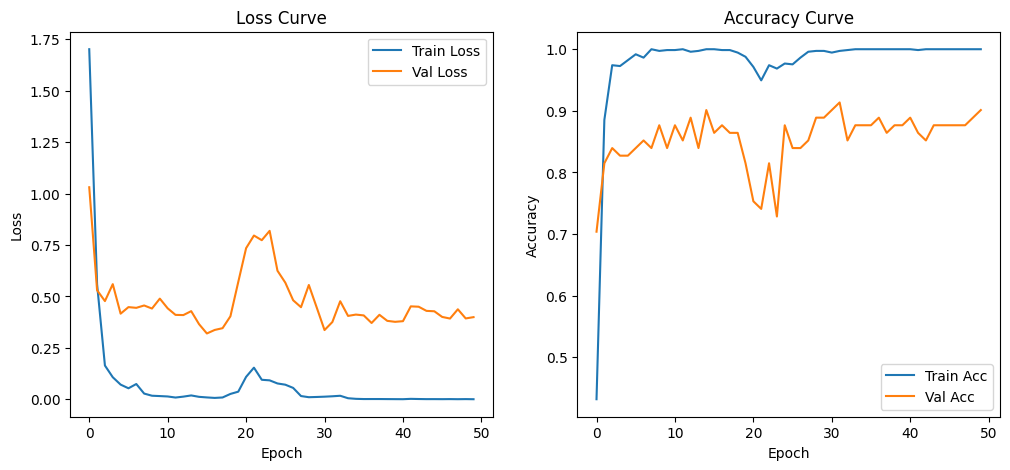

In [12]:
# ===============================================================
# 🔰 Plot Loss & Accuracy
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [13]:
# ===============================================================
# 🔰 Test evaluation
# ===============================================================
model.load_state_dict(torch.load("best_resnet50_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 85.71%
✅ Test time: 5.96 sec



Classification Report:
                       precision    recall  f1-score   support

      Genus Criconema     0.0000    0.0000    0.0000         1
  Genus Criconemoides     0.9500    0.9048    0.9268        21
Genus Helicotylenchus     1.0000    0.9200    0.9583        25
Genus Hemicycliophora     0.0000    0.0000    0.0000         1
 Genus Hirschmaniella     0.6897    0.9091    0.7843        22
    Genus Hoplolaimus     0.8571    0.9600    0.9057        25
    Genus Meloidogyne     0.9000    0.9000    0.9000        50
   Genus Pratylenchus     0.7917    0.6786    0.7308        28
     Genus Radopholus     0.5000    1.0000    0.6667         3
    Genus Trichodorus     0.9000    0.8182    0.8571        11
      Genus Xiphinema     0.9231    0.7500    0.8276        16

             accuracy                         0.8571       203
            macro avg     0.6829    0.7128    0.6870       203
         weighted avg     0.8615    0.8571    0.8544       203



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


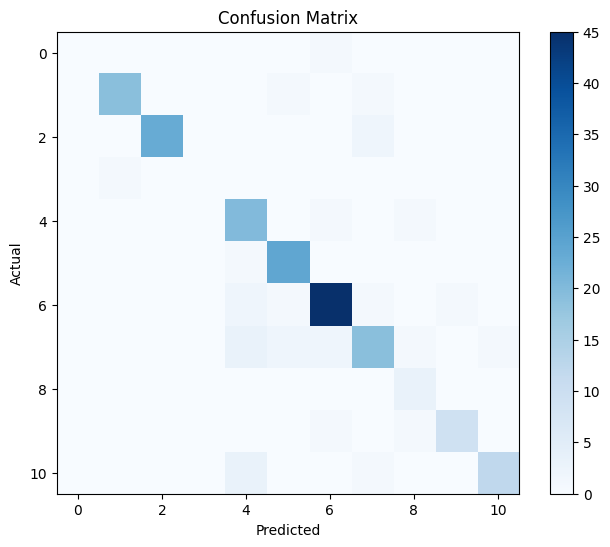


Per-class Accuracy:
Genus Criconema: 0.00%
Genus Criconemoides: 90.48%
Genus Helicotylenchus: 92.00%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 90.91%
Genus Hoplolaimus: 96.00%
Genus Meloidogyne: 90.00%
Genus Pratylenchus: 67.86%
Genus Radopholus: 100.00%
Genus Trichodorus: 81.82%
Genus Xiphinema: 75.00%


In [14]:

# ===============================================================
# 🔰 Classification report, Per-class accuracy & Confusion Matrix
# ===============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Model evaluation on test set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Only test set labels
unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# ✅ Per-class accuracy (fixed)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")



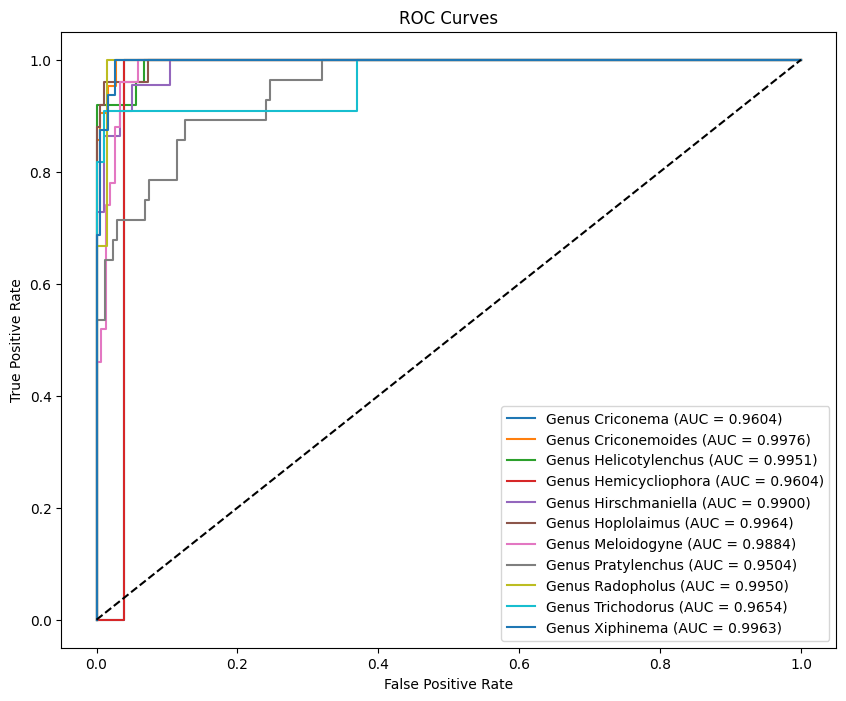

In [15]:
# ===============================================================
# 🔰 ROC-AUC per class (fixed)
# ===============================================================
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # Convert to boolean array for current class
    y_true = (all_labels_np == i).astype(int)  # 0/1 labels
    y_score = all_probs_np[:, i]               # predicted probability for class i

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [16]:
# Model GFLOPs & Params calculation
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # ResNet-50 input
flops, params = profile(model, inputs=(dummy_input,))

print(f"\n✅ Model Complexity:")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} M")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

✅ Model Complexity:
FLOPs: 4.13 GFLOPs
Parameters: 23.53 M
